In [1]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 500  

In [16]:
perturbation = 1 + 1e-1
filename = "1e-1.txt"

100%|██████████| 1001/1001 [00:04<00:00, 222.88it/s]


Saved distance data for node 535 (highest slope = 0.023888) to /Users/braydennoh/Documents/phasespace/2.24/lyapunov/1e-1.txt


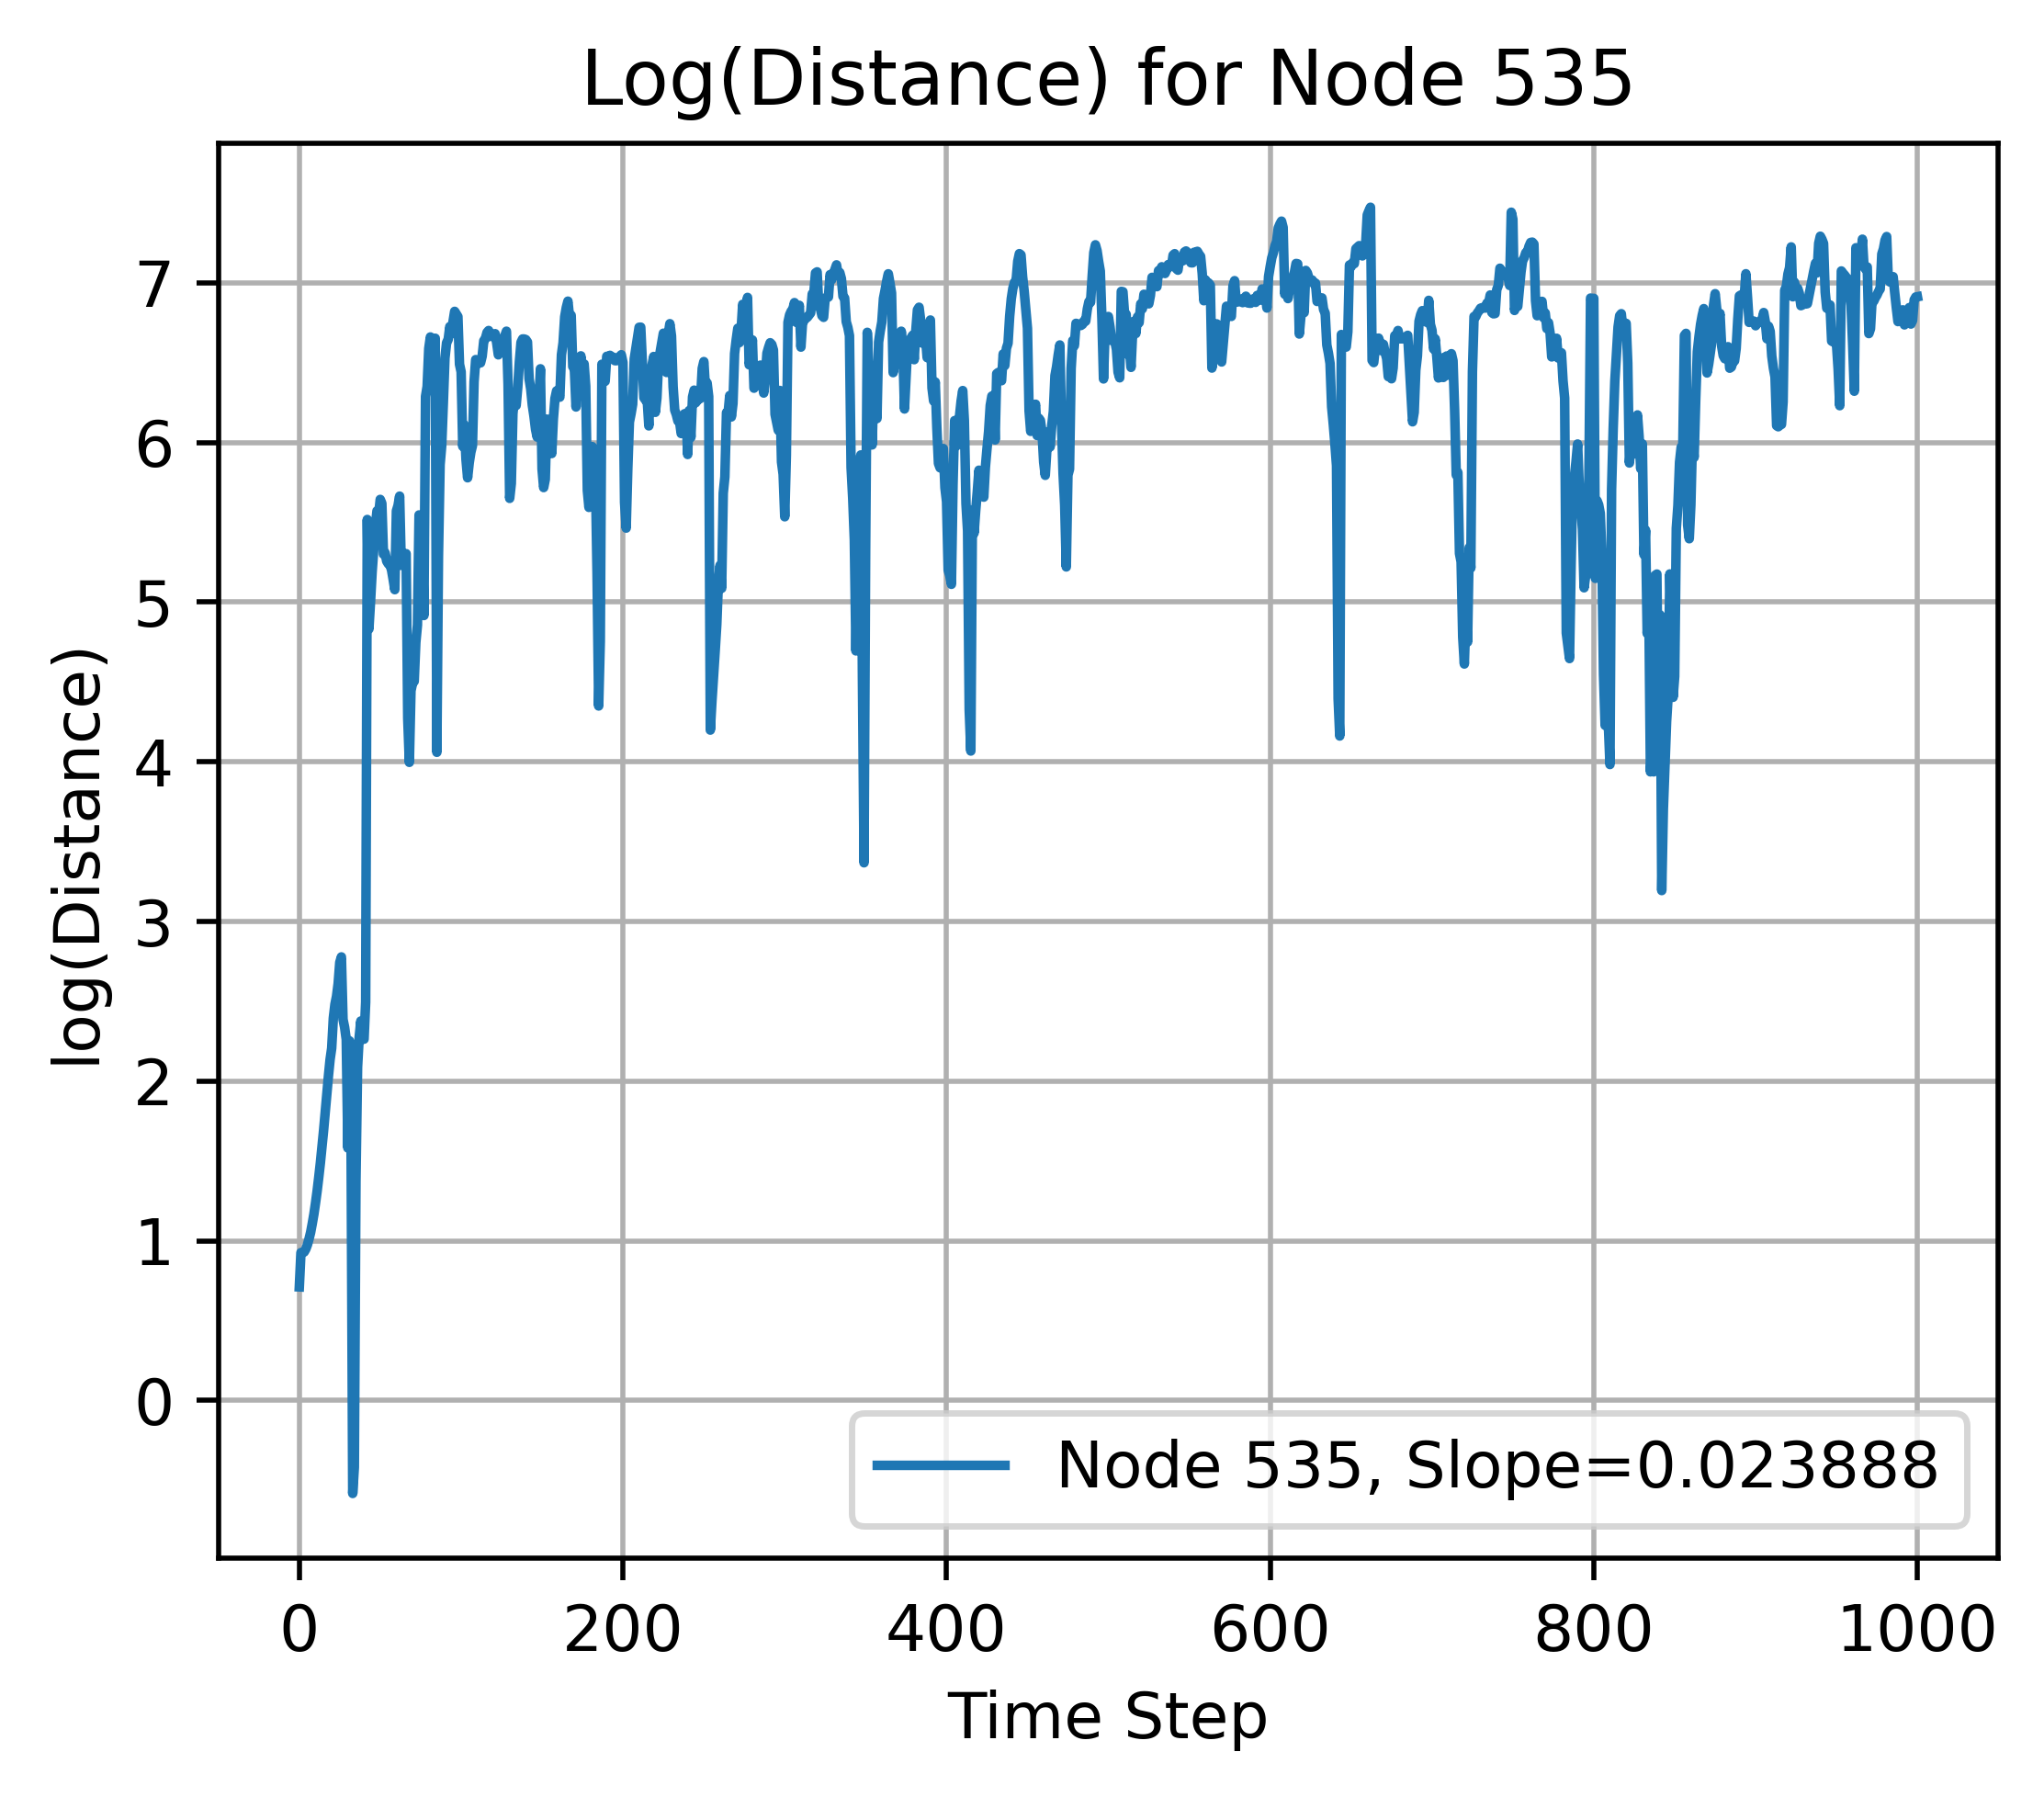

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
import meanderpy as mp

def run_meander_simulation(freq_multiplier, amplitude, multiplier):
    nit = 1001               
    W = 100.0                 
    D = 1.0                  
    depths = D * np.ones((nit,))
    pad = 50
    deltas = 100.0
    Cfs = 0.006 * np.ones((nit,))
    crdist = 10 * multiplier * W
    kl = 500.0 / (365 * 24 * 60 * 60.0) 
    kv = 1.0e-12
    dt = 0.1 * 0.5 * 365 * 24 * 60 * 60.0
    dens = 1000
    saved_ts = 1                
    Sl = 0.0
    t1, t2, t3 = 0, 0, 0
    aggr_factor = 2e-19
    
    x_initial = np.linspace(0.1, 20000, 3000)
    y_initial = (amplitude * 100) * np.sin(freq_multiplier * np.pi * x_initial / 1000.0)
    z_initial = np.zeros_like(x_initial)
    
    ch = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist, depths, Cfs, kl, kv, dt, dens, t1, t2, t3, aggr_factor)
    return chb

def resample_channel(x, y, num_points=10000):
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)
    s = np.concatenate(([0], np.cumsum(ds)))
    s_resampled = np.linspace(0, s[-1], num_points)
    x_resampled = interp1d(s, x, kind='linear')(s_resampled)
    y_resampled = interp1d(s, y, kind='linear')(s_resampled)
    return x_resampled, y_resampled

def compute_lyapunov_exponent_resampled_per_node(chb1, chb2):
    n_saved = min(len(chb1.channels), len(chb2.channels))
    num_nodes = 10000  
    distances_2D = np.zeros((num_nodes, n_saved))
    
    for t_idx in range(n_saved):
        x1, y1 = chb1.channels[t_idx].x, chb1.channels[t_idx].y
        x2, y2 = chb2.channels[t_idx].x, chb2.channels[t_idx].y
        
        x1_res, y1_res = resample_channel(x1, y1, num_points=num_nodes)
        x2_res, y2_res = resample_channel(x2, y2, num_points=num_nodes)
        
        node_distances = np.sqrt((x1_res - x2_res)**2 + (y1_res - y2_res)**2)
        distances_2D[:, t_idx] = node_distances
    
    return distances_2D

chb1 = run_meander_simulation(1, 1, 1)
chb2 = run_meander_simulation(1, perturbation, 1)

distances_2D = compute_lyapunov_exponent_resampled_per_node(chb1, chb2)

num_top_nodes = 10        
start_idx_fit = 10        
end_idx_fit   = 190       
start_idx_plot = 0        
end_idx_plot   = 1000     

save_path = "/Users/braydennoh/Documents/phasespace/2.24/lyapunov/"
os.makedirs(save_path, exist_ok=True)

num_nodes, n_times = distances_2D.shape
time_sub_fit = np.arange(start_idx_fit, end_idx_fit + 1)
slopes = np.zeros(num_nodes)

for i in range(num_nodes):
    node_dist = distances_2D[i, start_idx_fit:end_idx_fit+1]
    node_dist = np.clip(node_dist, 1e-15, None)
    log_dist = np.log(node_dist)
    slope, intercept = np.polyfit(time_sub_fit, log_dist, 1)
    slopes[i] = slope

max_slope_idx = np.argmax(slopes)
max_slope = slopes[max_slope_idx]

full_path = os.path.join(save_path, filename)
distance_over_time = distances_2D[max_slope_idx, start_idx_plot:end_idx_plot + 1]
distance_over_time = np.clip(distance_over_time, 1e-15, None)
np.savetxt(full_path, distance_over_time, fmt="%.6e")

print(f"Saved distance data for node {max_slope_idx} (highest slope = {max_slope:.6f}) to {full_path}")

time_sub_plot = np.arange(start_idx_plot, end_idx_plot + 1)

plt.figure(figsize=(5, 4))
plt.plot(time_sub_plot, np.log(distance_over_time), label=f'Node {max_slope_idx}, Slope={max_slope:.6f}')
plt.xlabel('Time Step')
plt.ylabel('log(Distance)')
plt.title(f'Log(Distance) for Node {max_slope_idx}')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
distances_2D

NameError: name 'distances_2D' is not defined